In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import LeakyReLU,multiply
from keras.layers import BatchNormalization
from keras.layers import Conv2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers.noise import GaussianNoise
import keras.backend as K
from keras.datasets import mnist

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


### generator

In [2]:
def build_generator(latent_size, num_class):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_size))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(256, kernel_size=3, strides=1, padding='same',
                              activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', 
                              activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', 
                              activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())  
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', 
                              activation='tanh', kernel_initializer='glorot_normal'))
    
    model.summary()

    # this is the z space commonly refered to in GAN papers
    latent_noise = Input(shape=(latent_size, ))

    # label
    image_label = Input(shape=(1,), dtype='int32')

    # 10 classes in MNIST
    embed = Embedding(num_class, latent_size, embeddings_initializer='glorot_normal')(image_label)
    label_embed = Flatten()(embed)

    model_input = multiply([latent_noise, label_embed])

    fake_image = model(model_input)
    gen_model =  Model(inputs=[latent_noise, image_label], outputs=fake_image)   
    return gen_model

### discriminator

In [3]:
def build_discriminator(img_shape, num_class):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape, kernel_initializer='glorot_normal'))
    #model.add(GaussianNoise(0.05, input_shape=(28, 28, 1))) 
    #model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.summary()
    
    image = Input(shape=img_shape)

    features = model(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    label = Dense(num_class + 1, activation='softmax', name='auxiliary')(features)
    disc_model = Model(inputs=image, outputs=[fake, label])
    return disc_model


### build model

In [4]:
latent_size = 100

# Adam parameters  https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

img_shape = (28, 28, 1)
num_class = 10

# build the discriminator
discriminator = build_discriminator(img_shape, num_class)
discriminator.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
                      loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])

# build the generator
generator = build_generator(latent_size, num_class)
generator.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1), 
                  loss='binary_crossentropy')

latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

discriminator.trainable = False
fake, aux = discriminator(fake)

combined = Model(inputs=[latent, image_class], outputs=[fake, aux])
combined.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
                 loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])

combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
__________

In [5]:
(X_train, y_train), (_, _) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)

In [6]:
def train(X_train, y_train, epochs=3, batch_size=64, sample_interval=50):

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    losses = []
    for epoch in range(epochs):
        #  Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        #noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        sampled_labels = np.random.randint(0, 10, (batch_size, 1))
        
        gen_imgs = generator.predict([noise, sampled_labels])
        img_labels = y_train[idx]
        fake_labels = 10 * np.ones(img_labels.shape)

        d_loss_real = discriminator.train_on_batch(imgs, [valid, img_labels])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #  Train Generator
        g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        losses.append((d_loss_real[0], d_loss_fake[0], d_loss[0], g_loss[0]))
        
        if epoch % sample_interval == 0:
            print ("epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1],  g_loss[0]))
            save_images(generator, epoch)
    return losses

In [7]:
import os
def save_images(generator, epoch):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])
    gen_imgs = generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
            
    if not os.path.exists("images"):
        os.makedirs("images")            
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [8]:
losses = train(X_train, y_train, epochs=3500, batch_size=64, sample_interval=100)

D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0 [D loss: 3.209059, acc.: 64.47%] [G loss: 3.193944]
epoch: 100 [D loss: 0.256219, acc.: 0.03%] [G loss: 1.838903]
epoch: 200 [D loss: 0.114352, acc.: 0.07%] [G loss: 0.537587]
epoch: 300 [D loss: 0.148201, acc.: 0.13%] [G loss: 0.266159]
epoch: 400 [D loss: 0.063065, acc.: 0.25%] [G loss: 0.301385]
epoch: 500 [D loss: 0.368798, acc.: 6.99%] [G loss: 12.002354]
epoch: 600 [D loss: 0.196742, acc.: 2.94%] [G loss: 0.740837]
epoch: 700 [D loss: 0.987249, acc.: 53.54%] [G loss: 8.641093]
epoch: 800 [D loss: 1.842375, acc.: 87.99%] [G loss: 4.871350]
epoch: 900 [D loss: 1.730732, acc.: 72.23%] [G loss: 3.352435]
epoch: 1000 [D loss: 1.430712, acc.: 70.17%] [G loss: 3.391946]
epoch: 1100 [D loss: 1.515302, acc.: 68.24%] [G loss: 3.145463]
epoch: 1200 [D loss: 1.576212, acc.: 70.34%] [G loss: 2.910950]
epoch: 1300 [D loss: 1.415855, acc.: 67.65%] [G loss: 2.697989]
epoch: 1400 [D loss: 1.695346, acc.: 84.78%] [G loss: 2.623060]
epoch: 1500 [D loss: 1.562347, acc.: 70.45%] [G loss: 2.5

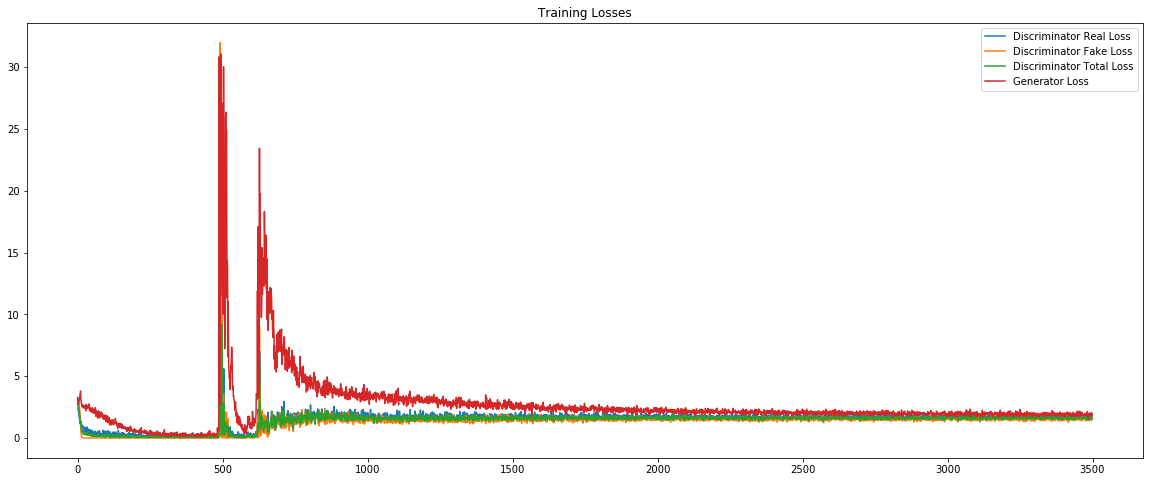

In [14]:
fig, ax = plt.subplots(figsize=(20,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Real Loss')
plt.plot(losses.T[1], label='Discriminator Fake Loss')
plt.plot(losses.T[2], label='Discriminator Total Loss')
plt.plot(losses.T[3], label='Generator Loss')
plt.title("Training Losses")
plt.legend()